In [194]:
import numpy as np
import scipy as sp
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from time import time as timer
import Branching_Process as bp
import pandas as pd
from tqdm import tqdm
import importlib
import seaborn as sns

#sns.set_palette()
cmap = sns.color_palette('tab10')
importlib.reload(bp)


<module 'Branching_Process' from '/Users/jacobcurran-sebastian/pgf_disc/Branching_Process.py'>

In [221]:
Tmax = 200
nsteps = 2*Tmax +1 
time = np.linspace(0, Tmax, num=nsteps)
time_step = time[1] - time[0]
R_eff = 3
t_lockdown = 30

eta = 0.2
eta2 = 0.5
# From FF100 data, Challen et al. 2021 Meta-analysis
gmean = 4.87
gsd = 1.98
alpha = gmean**2 / gsd**2
beta = gsd**2 / gmean

eta_vec = np.linspace(0.1, 1, num = 10)
R0_vec = 2*np.linspace(1.1, 4.1, num = 9)

def lifetime(t, tau):
    return sp.stats.gamma.cdf(t, a = alpha, scale = beta) # sp.stats.expon.cdf(t, scale = 1/gamma_test)

def lifetime_pdf(t, tau):
    return sp.stats.gamma.pdf(t, a = alpha, scale = beta)


def infectiousness(t):
    return sp.stats.gamma.cdf(t, a = alpha, scale = beta)

def infectiousness_pdf(t):
    return sp.stats.gamma.pdf(t, a = alpha, scale = beta)

def poisson_offspring(z, lamb = 1):
    return lamb*(z-1)

def R_constant(t, R=R_eff):
    return R



# Constant immigration
def scenario_1_im(t): 
    return eta*np.ones_like(t)

def scenario_2_im(t):
    return eta2 * np.ones_like(t)

# Exp increasing immigration
def scenario_3_im(t):
    return eta * np.exp(0.02*t)

def scenario_4_im(t):
    return eta * np.exp(-0.02*t)

def scenario_5_im(t, t_stop = 15):
    return eta * (t < t_stop)


def intensity_measure(t):
    return R_constant(t) * infectiousness_pdf(t) * (1-lifetime(t, 0))


R0_true = sp.integrate.quad(intensity_measure, 0, 100)[0]

print('R0 is: ' + str(R0_true))

R0 is: 1.5000000000000149


In [222]:


max_pgf = 20000

n_cores = 6
characteristic = 'prev'
scenarios = []
pmf_scenarios = []

for i, R in enumerate(R0_vec):
    if i !=0:
        continue
    cmj = bp.cmj(poisson_offspring, time=time)
    cmj.set_lifetime_distribution(lifetime)
    cmj.set_infectiousness_profile(infectiousness)
    def R_constant(t, R=R):
        return R

    cmj.set_transmission_rate(R_constant)

    start = timer()
    pmf_no_immigration = bp.pmfft(cmj.pgf_vec, 
                    max_pgf,
                    parallel = True,
                    n_cores = n_cores)
    stop = timer()
    print('Scenario ' + str(i) + ' no immigration finished in ' + str(np.round(stop - start, 2)) + ' seconds!')
    pmf_scenarios += [pmf_no_immigration]
    np.savetxt('./Scenarios/Heatmap/R=' + str(np.round(R/2, 2)) + '_pmf_noimmigration.csv', pmf_no_immigration)

    for j, im in enumerate(eta_vec):
        def immigration(t): 
            return im*np.ones_like(t)
        
        cmj.set_immigration(immigration)
        scenarios += [cmj]


        start = timer()
        pmf_immigration = bp.pmfft(cmj.pgf_immigration, 
                        max_pgf,
                        immigration = immigration,
                        parallel = True,
                        n_cores = n_cores)
        stop = timer()
    
        print('Scenario ' + str(i) + ', immigration scenario ' + str(j) + ' finished in ' + str(np.round(stop - start, 2)) + ' seconds!')
        pmf_scenarios += [pmf_immigration]

        np.savetxt('./Scenarios/Heatmap/R0=' + str(np.round(R/2, 2)) + '_pmf_immigration=' + str(im) + '.csv', pmf_immigration)


Scenario 0 no immigration finished in 1069.53 seconds!
Scenario 0, immigration scenario 0 finished in 1222.84 seconds!
Scenario 0, immigration scenario 1 finished in 1233.75 seconds!
Scenario 0, immigration scenario 2 finished in 1230.4 seconds!
Scenario 0, immigration scenario 3 finished in 1227.03 seconds!
Scenario 0, immigration scenario 4 finished in 1242.9 seconds!
Scenario 0, immigration scenario 5 finished in 1309.41 seconds!
Scenario 0, immigration scenario 6 finished in 1287.33 seconds!
Scenario 0, immigration scenario 7 finished in 1267.07 seconds!
Scenario 0, immigration scenario 8 finished in 1222.25 seconds!
Scenario 0, immigration scenario 9 finished in 1212.68 seconds!


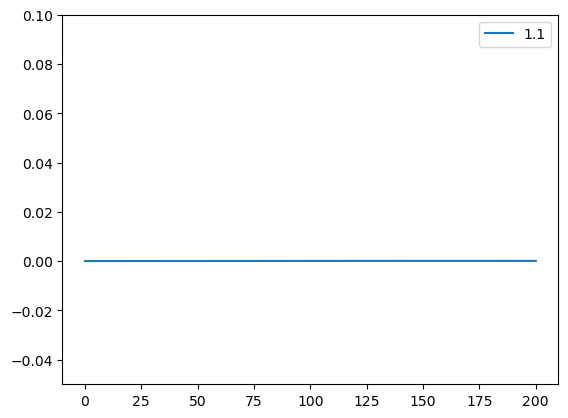

In [254]:
stats = np.zeros((len(R0_vec), len(eta_vec)))
stats2 = np.zeros((len(R0_vec), len(eta_vec)))
mean_array = np.zeros(len(R0_vec))
for i in range(len(R0_vec)):
    
    pmf_no_immigration = np.genfromtxt('./Scenarios/Heatmap/R=' + str(np.round(R0_vec[i]/2, 2)) + '_pmf_noimmigration.csv')
    #fpt_no_immigration = bp.FirstPassageTime(pmf_no_immigration, 100, time)
    Tmax_fpt = pmf_no_immigration.shape[1] - 1
    cdf_no_immigration = np.zeros_like(time[:Tmax_fpt])
    for k in range(Tmax_fpt):
        cdf_no_immigration[k] = (1-(np.cumsum(pmf_no_immigration[:100, k]))[-1])
    fpt_no_immigration = np.gradient(cdf_no_immigration, time_step)
    if i == 0:
        plt.plot(time, fpt_no_immigration, label = str(np.round(R0_vec[i]/2, 1)))
        plt.ylim([-0.05, 0.1])

    fpt_positive =  fpt_no_immigration>=0
    mean_array[i] = np.cumsum(fpt_no_immigration*time[:Tmax_fpt])[-1]
    for j in range(len(eta_vec)):
        
        pmf_immigration = np.genfromtxt('./Scenarios/Heatmap/R0=' + str(np.round(R0_vec[i]/2, 2)) + '_pmf_immigration=' + str(eta_vec[j]) + '.csv')
        #fpt_immigration = bp.FirstPassageTime(pmf_immigration, 100, time)
        cdf_immigration = np.zeros_like(time[:Tmax_fpt])
        for k in range(Tmax_fpt):
            cdf_immigration[k] = (1-(np.cumsum(pmf_immigration[:100, k]))[-1])
        fpt_immigration = np.gradient(cdf_immigration, time_step)
        fpt_positive =  fpt_immigration>=0

        stats[i, j] = np.cumsum(fpt_immigration*time[:Tmax_fpt])[-1]
        stats2[i, j] = np.cumsum(fpt_immigration*(time[:Tmax_fpt]**2))[-1] - stats[i, j]**2
        #if i == 0:
        #    plt.plot(time, fpt_immigration, label = 'im = ' + str(np.round(eta_vec[j], 1)))
        #    plt.ylim([0, 0.12])

plt.legend()

302

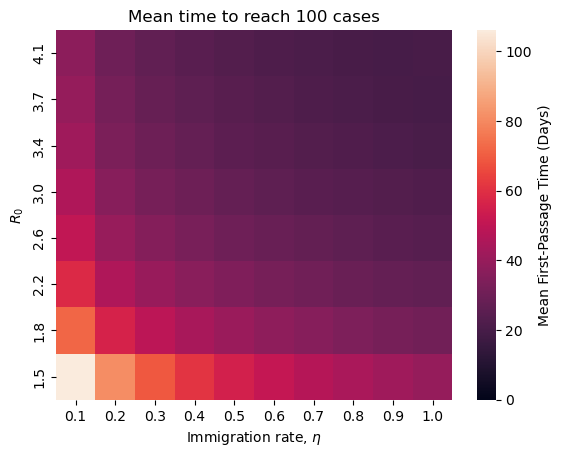

In [268]:
ax = sns.heatmap(stats[1:, :], fmt = 'f', cmap = 'rocket', cbar_kws={'label': 'Mean First-Passage Time (Days)'}, vmin=0)
ax.set_yticklabels([str(np.round(R0/2, 1)) for R0 in R0_vec[1:]])
ax.set_ylabel(r'$R_0$')
ax.set_xticklabels([str(np.round(et, 1)) for et in eta_vec])
ax.set_xlabel('Immigration rate, ' + r'$\eta$')
ax.set_title('Mean time to reach 100 cases')
ax.invert_yaxis()
plt.savefig('./Figures/Mean_FPT_scenarios.pdf')


In [243]:
one = np.genfromtxt('./Scenarios/Heatmap/R0=' + str(np.round(R0_vec[1]/2, 2)) + '_pmf_immigration=' + str(eta_vec[0]) + '.csv')
two = np.genfromtxt('./Scenarios/Heatmap/R0=' + str(np.round(R0_vec[-1]/2, 2)) + '_pmf_immigration=' + str(eta_vec[-1]) + '.csv')


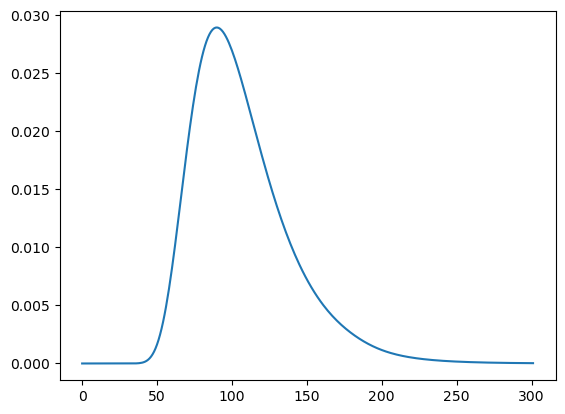

In [245]:
one_fpt = bp.FirstPassageTimeImmigration(one, 100, time[:302])
fpt_positive = one_fpt > 0
#np.sum(one - two)
plt.plot(one_fpt)
two_fpt = bp.FirstPassageTimeImmigration(two, 100, time[:302])
fpt_positive = two_fpt > 0

#plt.plot(two_fpt[:50])

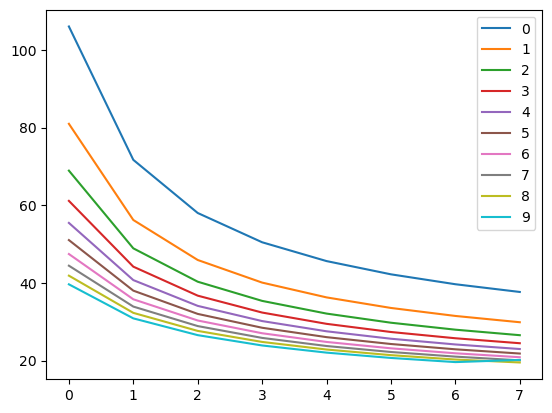

In [277]:
for i in range(stats[1:, :].shape[1]):
    plt.plot(stats[1:, i], label = i)
plt.legend()